## Setup

In [107]:
import pandas as pd
import numpy as np

from pandas.tools.plotting import scatter_matrix

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from patsy import dmatrix, dmatrices

%matplotlib inline

In [108]:
scaler = StandardScaler(copy=True)

In [109]:
train = pd.read_csv('data/raw/train.csv')
test = pd.read_csv('data/raw/test.csv')

## Data Investigation

In [110]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [111]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [112]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


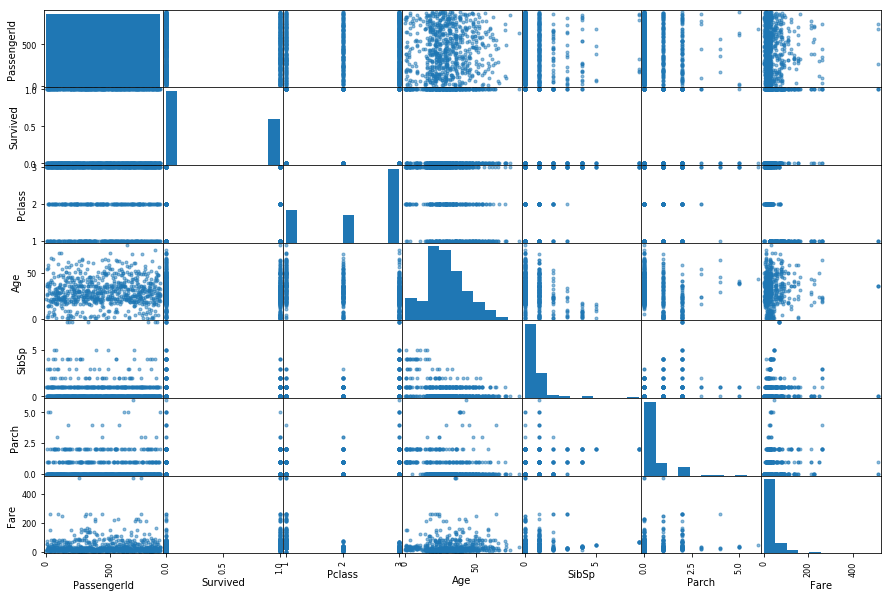

In [94]:
fig = scatter_matrix(train, figsize=(15,10))

## Missing Data Imputation and Feature Creation

In [113]:
#Guess most common class for missing values
train['Embarked'] = train.Embarked.replace(np.nan, train.Embarked.value_counts().idxmax())
test['Embarked'] = test.Embarked.replace(np.nan, train.Embarked.value_counts().idxmax())

In [114]:
#Replace missing Fare in Test with average 3rd class ticket
meanFare = train[train.Pclass == 3].Fare.mean()
test.Fare.fillna(meanFare, inplace=True)

In [115]:
train['Cabin'] = train.Cabin.replace(np.nan, 'Not-Reported')
test['Cabin'] = test.Cabin.replace(np.nan, 'Not-Reported')

In [116]:
train['CabinPrefix'] = [x[0] for x in train.Cabin]
test['CabinPrefix'] = [x[0] for x in test.Cabin]

In [117]:
train['Salutation'] = [x.split(',')[1].split(' ')[1] for x in train.Name]
test['Salutation'] = [x.split(',')[1].split(' ')[1] for x in test.Name]

In [118]:
#Average age for salutation
for sal in train.Salutation.unique():
    meanAge = round(train[train.Salutation == sal].Age.mean(), 0)
    train.loc[(train.Age.isnull()) & (train.Salutation == sal), 'Age'] = meanAge

In [119]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinPrefix,Salutation
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Not-Reported,S,N,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Not-Reported,S,N,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Not-Reported,S,N,Mr.
5,6,0,3,"Moran, Mr. James",male,32.0,0,0,330877,8.4583,Not-Reported,Q,N,Mr.
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,E,Mr.
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,Not-Reported,S,N,Master.
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,Not-Reported,S,N,Mrs.
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,Not-Reported,C,N,Mrs.


In [120]:
#Fill Age with mean for salutation and Pclass
train.Age = train.Fare.fillna(train.Age.mean())
test.Age = test.Fare.fillna(train.Age.mean())

In [121]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
CabinPrefix    891 non-null object
Salutation     891 non-null object
dtypes: float64(2), int64(5), object(7)
memory usage: 97.5+ KB


In [217]:
y, X = dmatrices('Survived ~ C(Pclass) + C(Sex) + Age + Fare + C(Embarked) + Parch + C(Salutation) + SibSp', train, return_type= 'dataframe')
X_test = dmatrix('C(Pclass) + C(Sex) + Age + Fare + Parch+ C(Embarked) + C(Salutation) + SibSp', test, return_type= 'dataframe')

In [218]:
X_test.shape

(418, 18)

In [219]:
X.shape

(891, 26)

Rectify Columns

In [220]:
def ColumnRect(train, test):
    for col in train.columns:
        if col not in test.columns:
            print('found one for test', col)
            test = pd.concat([test, pd.DataFrame(np.zeros([test.shape[0], 1]))], axis =1)
            colNames = list(test.columns)
            colNames[-1] = col
            test.columns = colNames
            print('col added to test: ', col)
            
    for col in test.columns:
        if col not in train.columns:
            train = pd.concat([train, pd.DataFrame(np.zeros([train.shape[0], 1]))], axis =1)
            colNames = list(train.columns)
            colNames[-1] = col
            train.columns = colNames
            print('col added to train: ', col)
        
    #sort the resulting columns'
    train = train.reindex_axis(sorted(train.columns), axis=1)
    test = test.reindex_axis(sorted(test.columns), axis=1)
    
    if (train.columns == test.columns).all():
        print('Column Rect. Complete')
            
    return(train, test)

In [221]:
X, X_test = ColumnRect(X, X_test)

found one for test C(Salutation)[T.Col.]
col added to test:  C(Salutation)[T.Col.]
found one for test C(Salutation)[T.Don.]
col added to test:  C(Salutation)[T.Don.]
found one for test C(Salutation)[T.Jonkheer.]
col added to test:  C(Salutation)[T.Jonkheer.]
found one for test C(Salutation)[T.Lady.]
col added to test:  C(Salutation)[T.Lady.]
found one for test C(Salutation)[T.Major.]
col added to test:  C(Salutation)[T.Major.]
found one for test C(Salutation)[T.Mlle.]
col added to test:  C(Salutation)[T.Mlle.]
found one for test C(Salutation)[T.Mme.]
col added to test:  C(Salutation)[T.Mme.]
found one for test C(Salutation)[T.Sir.]
col added to test:  C(Salutation)[T.Sir.]
found one for test C(Salutation)[T.the]
col added to test:  C(Salutation)[T.the]
col added to train:  C(Salutation)[T.Dona.]
Column Rect. Complete


In [222]:
Xsc = pd.DataFrame(scaler.fit(X).transform(X))
Xsc.columns = X.columns

In [223]:
X_test.head()

,Age,C(Embarked)[T.Q],C(Embarked)[T.S],C(Pclass)[T.2],C(Pclass)[T.3],C(Salutation)[T.Col.],C(Salutation)[T.Don.],C(Salutation)[T.Dona.],C(Salutation)[T.Dr.],C(Salutation)[T.Jonkheer.],...,C(Salutation)[T.Mrs.],C(Salutation)[T.Ms.],C(Salutation)[T.Rev.],C(Salutation)[T.Sir.],C(Salutation)[T.the],C(Sex)[T.male],Fare,Intercept,Parch,SibSp
0,7.8292,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,7.8292,1.0,0.0,0.0
1,7.0000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,7.0000,1.0,0.0,1.0
2,9.6875,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,9.6875,1.0,0.0,0.0
3,8.6625,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,8.6625,1.0,0.0,0.0
4,12.2875,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,12.2875,1.0,1.0,1.0


In [224]:
Xsc_test = pd.DataFrame(scaler.fit(X).transform(X_test))
Xsc_test.columns = X.columns

In [225]:
Xsc.shape

(891, 27)

In [226]:
Xsc_test.shape

(418, 27)

In [227]:
lr = SVC()
parameters = {'C': np.logspace(-4, 4, 10)}
clf = GridSearchCV(lr, parameters, cv = 10, verbose=False)

In [228]:
clf.fit(Xsc, y.Survived)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-04,   7.74264e-04,   5.99484e-03,   4.64159e-02,
         3.59381e-01,   2.78256e+00,   2.15443e+01,   1.66810e+02,
         1.29155e+03,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=False)

In [229]:
clf.best_params_, clf.best_score_

({'C': 2.7825594022071258}, 0.83613916947250277)

In [230]:
submit = clf.predict(Xsc_test)

In [231]:
Xsc_test.head()

,Age,C(Embarked)[T.Q],C(Embarked)[T.S],C(Pclass)[T.2],C(Pclass)[T.3],C(Salutation)[T.Col.],C(Salutation)[T.Don.],C(Salutation)[T.Dona.],C(Salutation)[T.Dr.],C(Salutation)[T.Jonkheer.],...,C(Salutation)[T.Mrs.],C(Salutation)[T.Ms.],C(Salutation)[T.Rev.],C(Salutation)[T.Sir.],C(Salutation)[T.the],C(Sex)[T.male],Fare,Intercept,Parch,SibSp
0,-0.490783,3.251373,-1.623803,-0.510152,0.902587,-0.047431,-0.03352,0.0,-0.088986,-0.03352,...,-0.403962,-0.03352,-0.082339,-0.03352,-0.03352,0.737695,-0.490783,0.0,-0.473674,-0.474545
1,-0.507479,-0.307562,0.615838,-0.510152,0.902587,-0.047431,-0.03352,0.0,-0.088986,-0.03352,...,2.475480,-0.03352,-0.082339,-0.03352,-0.03352,-1.355574,-0.507479,0.0,-0.473674,0.432793
2,-0.453367,3.251373,-1.623803,1.960202,-1.107926,-0.047431,-0.03352,0.0,-0.088986,-0.03352,...,-0.403962,-0.03352,-0.082339,-0.03352,-0.03352,0.737695,-0.453367,0.0,-0.473674,-0.474545
3,-0.474005,-0.307562,0.615838,-0.510152,0.902587,-0.047431,-0.03352,0.0,-0.088986,-0.03352,...,-0.403962,-0.03352,-0.082339,-0.03352,-0.03352,0.737695,-0.474005,0.0,-0.473674,-0.474545
4,-0.401017,-0.307562,0.615838,-0.510152,0.902587,-0.047431,-0.03352,0.0,-0.088986,-0.03352,...,2.475480,-0.03352,-0.082339,-0.03352,-0.03352,-1.355574,-0.401017,0.0,0.767630,0.432793


In [232]:
submission = pd.concat([test.PassengerId, pd.DataFrame(submit)], axis = 1)
submission.index = submission.PassengerId
submission = submission.drop('PassengerId', axis = 1)
submission.columns = ['Survived']
submission.Survived = submission.Survived.astype(int)

In [233]:
submission.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [234]:
clf.best_estimator_

SVC(C=2.7825594022071258, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [235]:
submission.to_csv('QP_titanicSubmit_svc.csv')